<a href="https://colab.research.google.com/github/hmezer/dai-project/blob/main/model_checkup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial Setup

In [12]:
!git clone https://github.com/hmezer/dai-project

Cloning into 'dai-project'...
remote: Enumerating objects: 212, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 212 (delta 27), reused 4 (delta 4), pack-reused 150 (from 1)
Receiving objects: 100% (212/212), 125.06 MiB | 20.89 MiB/s, done.
Resolving deltas: 100% (94/94), done.
Updating files: 100% (32/32), done.


In [13]:
# extract the zip content at dai-project/data/nasdaq-sentiment.zip
!unzip -o dai-project/models/lgb_models.zip -d lgb-models/

Archive:  dai-project/models/lgb_models.zip
   creating: lgb-models/lgb_models/
  inflating: lgb-models/lgb_models/model_future_1D_Return_log_exclude_past_1M_max_gain.txt  
  inflating: lgb-models/lgb_models/model_future_1W_volatility_exclude_past_1D_Return_log.txt  
  inflating: lgb-models/lgb_models/model_future_1M_Return_CUML_log_exclude_past_1W_momentum.txt  
  inflating: lgb-models/lgb_models/model_future_1W_Return_CUML_log_all_features.txt  
  inflating: lgb-models/lgb_models/model_future_1W_Return_CUML_log_exclude_past_1W_direction.txt  
  inflating: lgb-models/lgb_models/model_future_1W_Return_CUML_log_exclude_past_1M_direction.txt  
  inflating: lgb-models/lgb_models/model_future_1W_Return_CUML_log_exclude_past_1M_momentum.txt  
  inflating: lgb-models/lgb_models/model_future_1M_momentum_exclude_Polarity_immediate.txt  
  inflating: lgb-models/lgb_models/model_future_1W_volatility_exclude_Polarity_pure.txt  
  inflating: lgb-models/lgb_models/model_future_1W_momentum_exclude_p

In [14]:
import os
import lightgbm as lgb

model_dir = 'lgb-models/lgb_models/'
model_files = os.listdir(model_dir)

models = {}
for model_file in model_files:
    model_path = os.path.join(model_dir, model_file)
    # Extract target name and excluded feature from the file name
    model_name = os.path.splitext(model_file)[0]
    parts = model_name.replace('model_', '').split('_exclude_')

    if len(parts) > 1:
        target_name = '_'.join(parts[:-1])
        excluded_feature = parts[-1]
    else:
        target_name = model_name.replace('model_', '').replace('_all_features', '')
        excluded_feature = "baseline" # Use "baseline" for models with all features

    try:
        if target_name not in models:
            models[target_name] = {}
        models[target_name][excluded_feature] = lgb.Booster(model_file=model_path)
        print(f"Loaded model for target '{target_name}' with excluded feature '{excluded_feature}'")
    except Exception as e:
        print(f"Error loading model {model_name}: {e}")

print(f"\nTotal models loaded: {sum(len(target_models) for target_models in models.values())}")

Loaded model for target 'future_1W_volatility' with excluded feature 'past_1W_Return_COMP_log'
Loaded model for target 'future_1M_volatility' with excluded feature 'past_1M_Return_COMP_log'
Loaded model for target 'future_1W_momentum' with excluded feature 'past_1M_drawdown'
Loaded model for target 'future_1W_Return_CUML_log' with excluded feature 'past_1M_direction'
Loaded model for target 'future_1M_volatility' with excluded feature 'past_1M_drawdown'
Loaded model for target 'future_1W_volatility' with excluded feature 'baseline'
Loaded model for target 'future_1W_volatility' with excluded feature 'past_1M_drawdown'
Loaded model for target 'future_1M_momentum' with excluded feature 'past_1W_volatility'
Loaded model for target 'future_1W_Return_CUML_log' with excluded feature 'past_1M_momentum'
Loaded model for target 'future_1W_momentum' with excluded feature 'past_1D_Return_log'
Loaded model for target 'future_1M_momentum' with excluded feature 'baseline'
Loaded model for target 'fu

In [15]:
models

{'future_1W_volatility': {'past_1W_Return_COMP_log': <lightgbm.basic.Booster at 0x7996f03d0800>,
  'baseline': <lightgbm.basic.Booster at 0x7996f037eff0>,
  'past_1M_drawdown': <lightgbm.basic.Booster at 0x7996f037f080>,
  'past_1M_Return_COMP_log': <lightgbm.basic.Booster at 0x7996f034ec30>,
  'past_1M_volatility': <lightgbm.basic.Booster at 0x7996f034f350>,
  'past_1M_max_gain': <lightgbm.basic.Booster at 0x7996f03e8b90>,
  'past_1W_momentum': <lightgbm.basic.Booster at 0x7996f03e9850>,
  'past_1W_max_gain': <lightgbm.basic.Booster at 0x7996f03e9b80>,
  'past_1W_volatility': <lightgbm.basic.Booster at 0x7996f03ebb30>,
  'past_1W_drawdown': <lightgbm.basic.Booster at 0x7996f041e570>,
  'past_1M_momentum': <lightgbm.basic.Booster at 0x7996f02e8bc0>,
  'past_1D_direction': <lightgbm.basic.Booster at 0x7996f02e8f20>,
  'past_1M_direction': <lightgbm.basic.Booster at 0x7996f02e98b0>,
  'Polarity_pure': <lightgbm.basic.Booster at 0x7996f03108c0>,
  'past_1D_Return_log': <lightgbm.basic.Boo

In [19]:
import pandas as pd
import os

# List files in the current directory
dir_path = 'dai-project/data/'
files = os.listdir(dir_path)

# Filter for files starting with "stock_with_features_polarities" and ending with ".csv"
csv_files = [f for f in files if f.startswith('stock_with_features_polarities') and f.endswith('.csv')]

# Read and concatenate the CSV files into a single DataFrame
dfs = []
for csv_file in csv_files:
    try:
        df_temp = pd.read_csv(dir_path + csv_file)
        dfs.append(df_temp)
        print(f"Loaded {csv_file}")
    except Exception as e:
        print(f"Error loading {csv_file}: {e}")

if dfs:
    df = pd.concat(dfs, ignore_index=True)
    print("\nSuccessfully concatenated all files into 'df'")
    display(df.head())
else:
    print("No files found starting with 'stock_with_features_polarities' and ending with '.csv'")
    df = pd.DataFrame() # Create an empty DataFrame if no files are found

Loaded stock_with_features_polarities_chunk_1.csv
Loaded stock_with_features_polarities_chunk_2.csv

Successfully concatenated all files into 'df'


,Date,Open,High,Low,Close,Volume,OpenAdjusted,HighAdjusted,LowAdjusted,CloseAdjusted,...,past_1W_drawdown,past_1M_drawdown,past_1W_max_gain,past_1M_max_gain,past_1D_direction,past_1W_direction,past_1M_direction,Polarity_diluted,Polarity_pure,Polarity_immediate
0,2007-02-01,98.97,99.1800,97.96,99.00,3395900,54.7297,54.8458,54.1712,54.7463,...,0.016061,0.028687,0.003737,0.017375,0,1,1,0.050998,0.458978,0.000000
1,2007-02-01,17.22,17.3400,17.03,17.04,28314541,14.0578,14.1557,13.9027,13.9108,...,0.000000,0.003522,0.013500,0.047539,0,1,0,0.237683,0.716868,0.000000
2,2007-02-01,37.95,39.3000,37.85,38.70,14444068,1.8975,1.9650,1.8925,1.9350,...,0.048579,0.058656,0.000000,0.005426,1,1,0,0.213643,0.638460,0.333333
3,2007-02-01,20.98,21.1400,20.87,21.10,47253855,12.6759,12.7726,12.6094,12.7484,...,0.026537,0.026537,0.000000,0.055929,1,1,1,0.269844,0.782548,1.000000
4,2007-02-01,22.69,23.1001,22.65,22.74,1041583,3.2414,3.3000,3.2357,3.2486,...,0.007049,0.044850,0.016253,0.113895,0,0,0,0.269844,0.782548,1.000000


# Model Checkup

In [20]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd

# model: your loaded LightGBM model (can be Booster, LGBMClassifier, LGBMRegressor)
# X_test: your test set (as DataFrame), used for feature names

def show_feature_importance(model, X_test):
    # Get feature names
    feature_names = X_test.columns if hasattr(X_test, 'columns') else [f'feature_{i}' for i in range(X_test.shape[1])]

    # Get importance values
    importance_gain = model.feature_importances_ if hasattr(model, 'feature_importances_') else model.feature_importance(importance_type='gain')
    importance_split = model.feature_importance(importance_type='split') if hasattr(model, 'feature_importance') else None

    # Create DataFrame for gain
    df_gain = pd.DataFrame({
        'feature': feature_names,
        'importance_gain': importance_gain
    }).sort_values(by='importance_gain', ascending=False)

    print("Feature importance (gain):")
    print(df_gain)

    # Plot importance (gain)
    plt.figure(figsize=(8, 6))
    plt.barh(df_gain['feature'], df_gain['importance_gain'])
    plt.xlabel('Importance (gain)')
    plt.title('Feature Importance (Gain)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    # If split importance available, print and optionally plot
    if importance_split is not None:
        df_split = pd.DataFrame({
            'feature': feature_names,
            'importance_split': importance_split
        }).sort_values(by='importance_split', ascending=False)

        print("\nFeature importance (split):")
        print(df_split)

        plt.figure(figsize=(8, 6))
        plt.barh(df_split['feature'], df_split['importance_split'])
        plt.xlabel('Importance (split)')
        plt.title('Feature Importance (Split)')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

# Usage example:
# show_feature_importance(model, X_test)

Feature importance (gain):
                    feature  importance_gain
15            Polarity_pure         6.026568
0        past_1D_Return_log         5.798926
4        past_1M_volatility         5.329740
14         Polarity_diluted         5.303722
3        past_1W_volatility         4.327719
6          past_1M_momentum         3.969534
8          past_1M_drawdown         3.846170
10         past_1M_max_gain         3.704226
2   past_1M_Return_COMP_log         3.406950
5          past_1W_momentum         3.030566
1   past_1W_Return_COMP_log         2.902116
7          past_1W_drawdown         2.766280
9          past_1W_max_gain         2.718301
16       Polarity_immediate         1.346958
11        past_1D_direction         0.000000
12        past_1W_direction         0.000000
13        past_1M_direction         0.000000


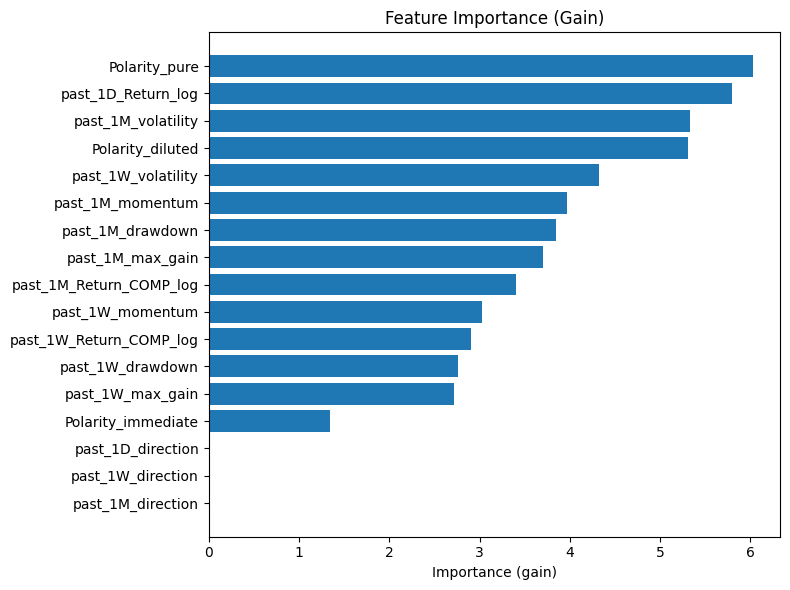


Feature importance (split):
                    feature  importance_split
4        past_1M_volatility               532
15            Polarity_pure               523
0        past_1D_Return_log               506
14         Polarity_diluted               479
3        past_1W_volatility               421
8          past_1M_drawdown               379
6          past_1M_momentum               361
10         past_1M_max_gain               359
2   past_1M_Return_COMP_log               348
9          past_1W_max_gain               310
5          past_1W_momentum               297
7          past_1W_drawdown               296
1   past_1W_Return_COMP_log               294
16       Polarity_immediate               123
11        past_1D_direction                 0
12        past_1W_direction                 0
13        past_1M_direction                 0


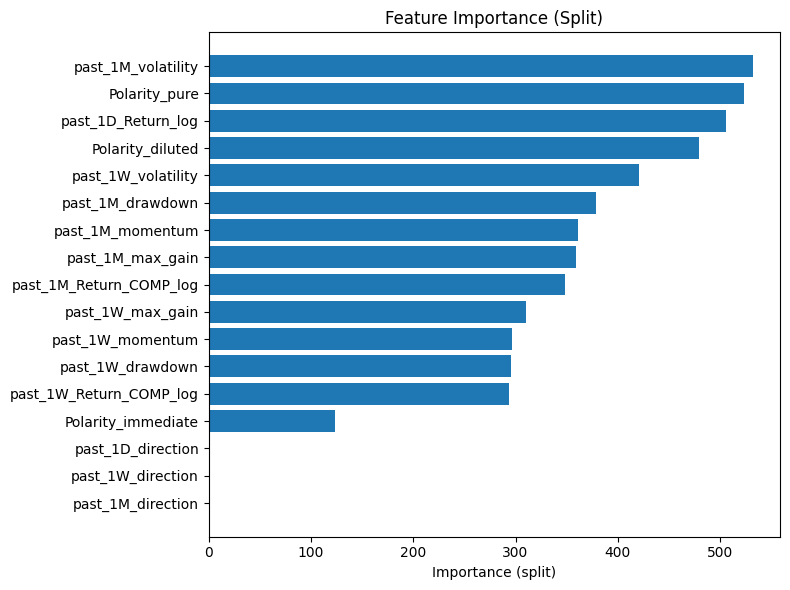

In [27]:
model = models['future_1D_Return_log']['baseline']
show_feature_importance(model, df[[col for col in model.feature_name()]])

In [28]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd

def show_feature_importance(model, X_test):
    feature_names = X_test.columns if hasattr(X_test, 'columns') else [f'feature_{i}' for i in range(X_test.shape[1])]
    importance_gain = model.feature_importances_ if hasattr(model, 'feature_importances_') else model.feature_importance(importance_type='gain')
    df_gain = pd.DataFrame({
        'feature': feature_names,
        'importance_gain': importance_gain
    }).sort_values(by='importance_gain', ascending=False)

    print("Feature importance (gain):")
    print(df_gain)

    # Color bins red if 'Polarity' in feature name, else blue
    colors = ['red' if 'Polarity' in feat else 'blue' for feat in df_gain['feature']]

    plt.figure(figsize=(8, 6))
    bars = plt.barh(df_gain['feature'], df_gain['importance_gain'], color=colors)
    plt.xlabel('Importance (gain)')
    plt.title('Feature Importance (Gain)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# Usage example:
# show_feature_importance(model, X_test)

Feature importance (gain):
                    feature  importance_gain
15            Polarity_pure         6.026568
0        past_1D_Return_log         5.798926
4        past_1M_volatility         5.329740
14         Polarity_diluted         5.303722
3        past_1W_volatility         4.327719
6          past_1M_momentum         3.969534
8          past_1M_drawdown         3.846170
10         past_1M_max_gain         3.704226
2   past_1M_Return_COMP_log         3.406950
5          past_1W_momentum         3.030566
1   past_1W_Return_COMP_log         2.902116
7          past_1W_drawdown         2.766280
9          past_1W_max_gain         2.718301
16       Polarity_immediate         1.346958
11        past_1D_direction         0.000000
12        past_1W_direction         0.000000
13        past_1M_direction         0.000000


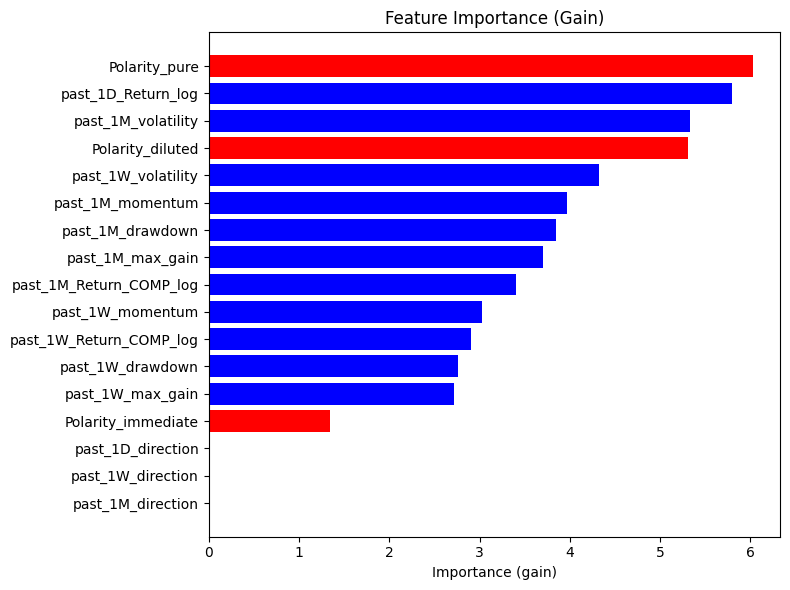

In [29]:
model = models['future_1D_Return_log']['baseline']
show_feature_importance(model, df[[col for col in model.feature_name()]])